# Figure 8

Nnotebook to create plots for figure 8


Mean A) pCO2 and B) net CO2flux over 1982-2018 estimated from LDEO-HPD. 
A spatially complete map of CO2 flux is achieved by filling in gaps with a trend plus climatology

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.print_figure_kwargs = {'dpi':300, 'bbox_inches': 'tight'}

# standard imports
import os
import scipy
import numpy as np
import xarray as xr
import pandas as pd
import glob

# modeling
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pgml

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# plotting
import cmocean as cm
import matplotlib as mpl
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from matplotlib.ticker import AutoMinorLocator
from plotting_tools.spatial_map import SpatialMap
from plotting_tools.time_series_diagram import TimeSeriesPlot

# regression metrics
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
#from sklearn.metrics import explained_variance_score

%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.print_figure_kwargs = {'dpi':300, 'bbox_inches': 'tight'}
import numpy as np
import pandas as pd
import xarray as xr
import xarray.ufuncs as xu
import cmocean as cm
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Makes world maps
import matplotlib.pyplot as plt
from plotting_tools.spatial_map import SpatialMap
from plotting_tools.time_series_diagram import TimeSeriesPlot
from plotting_tools.utils import xr_add_cyclic_point

import pgml
import os
# settings 
pd.set_option("display.max_columns", 100)

In [12]:
dir_figs = '/home/gloege/projects/ldeo_hpd/reports/figures'

# Load data

In [13]:
%%time
ds_hpd = xr.open_dataset('/local/data/artemis/workspace/gloege/ldeo-hpd/LDEO-HPD_fgco2_v20210426_1x1_198201-201812.nc')

# convert to mol/m2/yr
sec_to_year = 86400 * 365       # sec/year
ds_hpd = (ds_hpd*sec_to_year).mean('model')

/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CPU times: user 2.42 s, sys: 4.56 s, total: 6.99 s
Wall time: 7 s


# Flux

<Figure size 460.8x316.8 with 0 Axes>

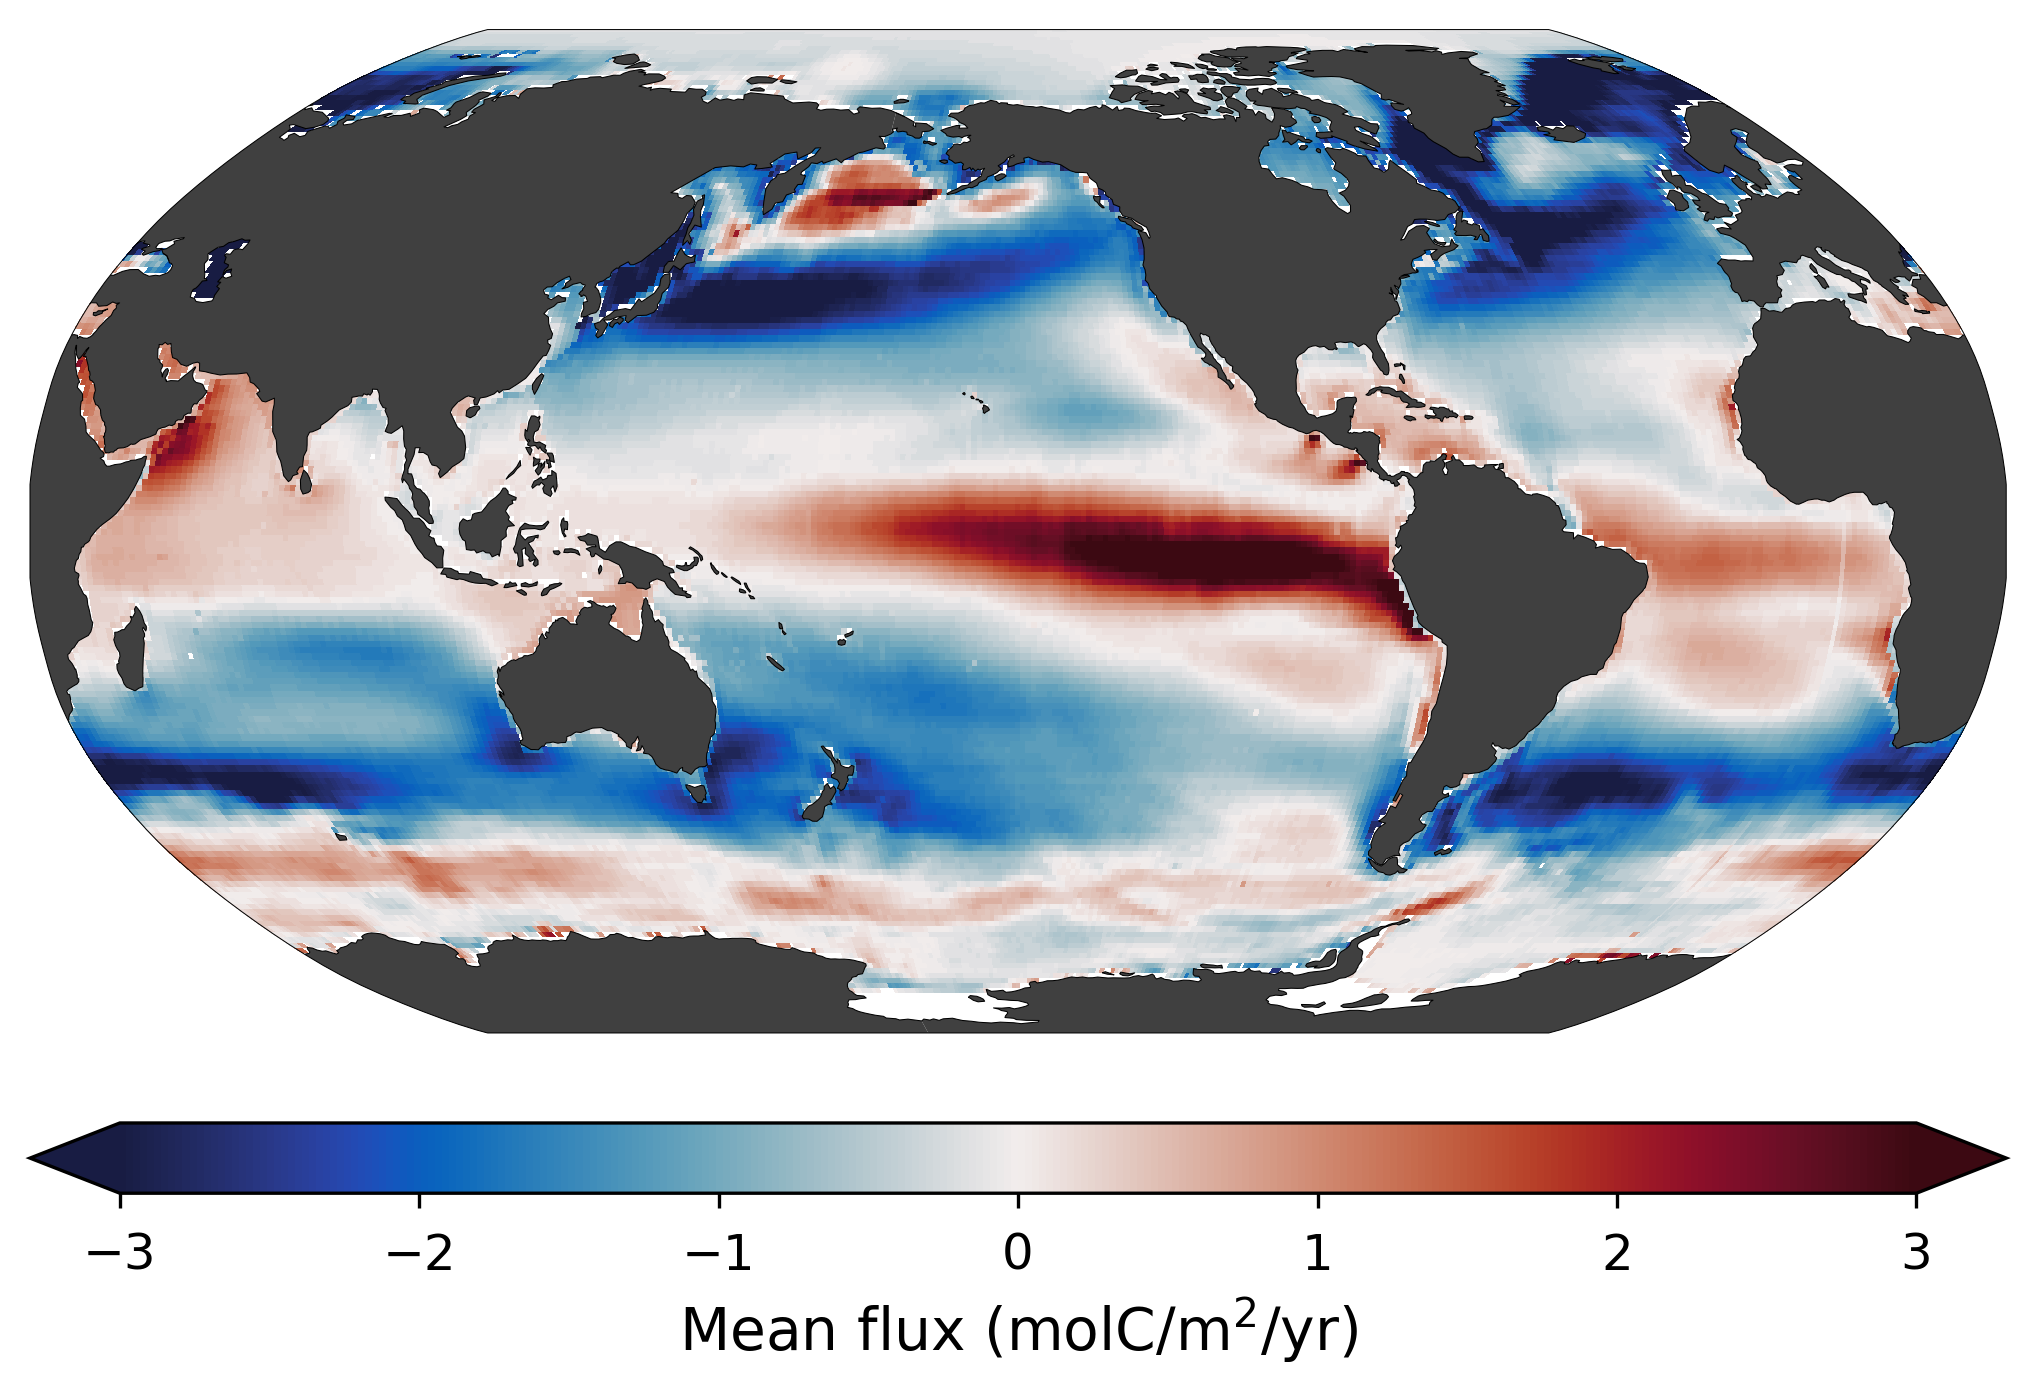

In [14]:
# colormap
vrange = [-3, 3, 1]
#cmap = cm.cm.thermal
cmap = cm.cm.balance

# data to plot
data = ds_hpd['fgco2_avg'].mean(['time'])
#data = (ds_hpd['fgco2']*86400*365).mean(['time'])
data = xr_add_cyclic_point(data, cyclic_coord='lon') 

# make figure
with plt.style.context('seaborn-paper'):
    fig = plt.figure()
    dia = SpatialMap(cbar_location='bottom', cbar_orientation='horizontal')
    sub = dia.add_plot(lat = data['lat'], 
                       lon = data['lon'], 
                       data = data, 
                       vrange=vrange[0:2], 
                       cmap=cmap, 
                       ax=0)
    
    col = dia.add_colorbar(sub, ax=0, extend='both')
    col.ax.tick_params(labelsize=12)
    dia.set_cbar_xlabel(col, 'Mean flux (molC/m$^2$/yr)', fontsize=14)
    col.set_ticks(ticks=np.arange(vrange[0], vrange[1]+vrange[2], vrange[2]))
    

plt.savefig(f'{dir_figs}/mean_flux_latest.pdf', 
                transparent = True, 
                bbox_inches = 'tight', 
                pad_inches = 0)

# map of spco2

In [15]:
%%time
ds_spco2 = xr.open_dataset('/local/data/artemis/workspace/gloege/ldeo-hpd/LDEO-HPD_v20210425_1x1_198201-201812.nc').mean('model')

/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CPU times: user 3.46 s, sys: 5.39 s, total: 8.84 s
Wall time: 8.86 s


<Figure size 1920x1320 with 0 Axes>

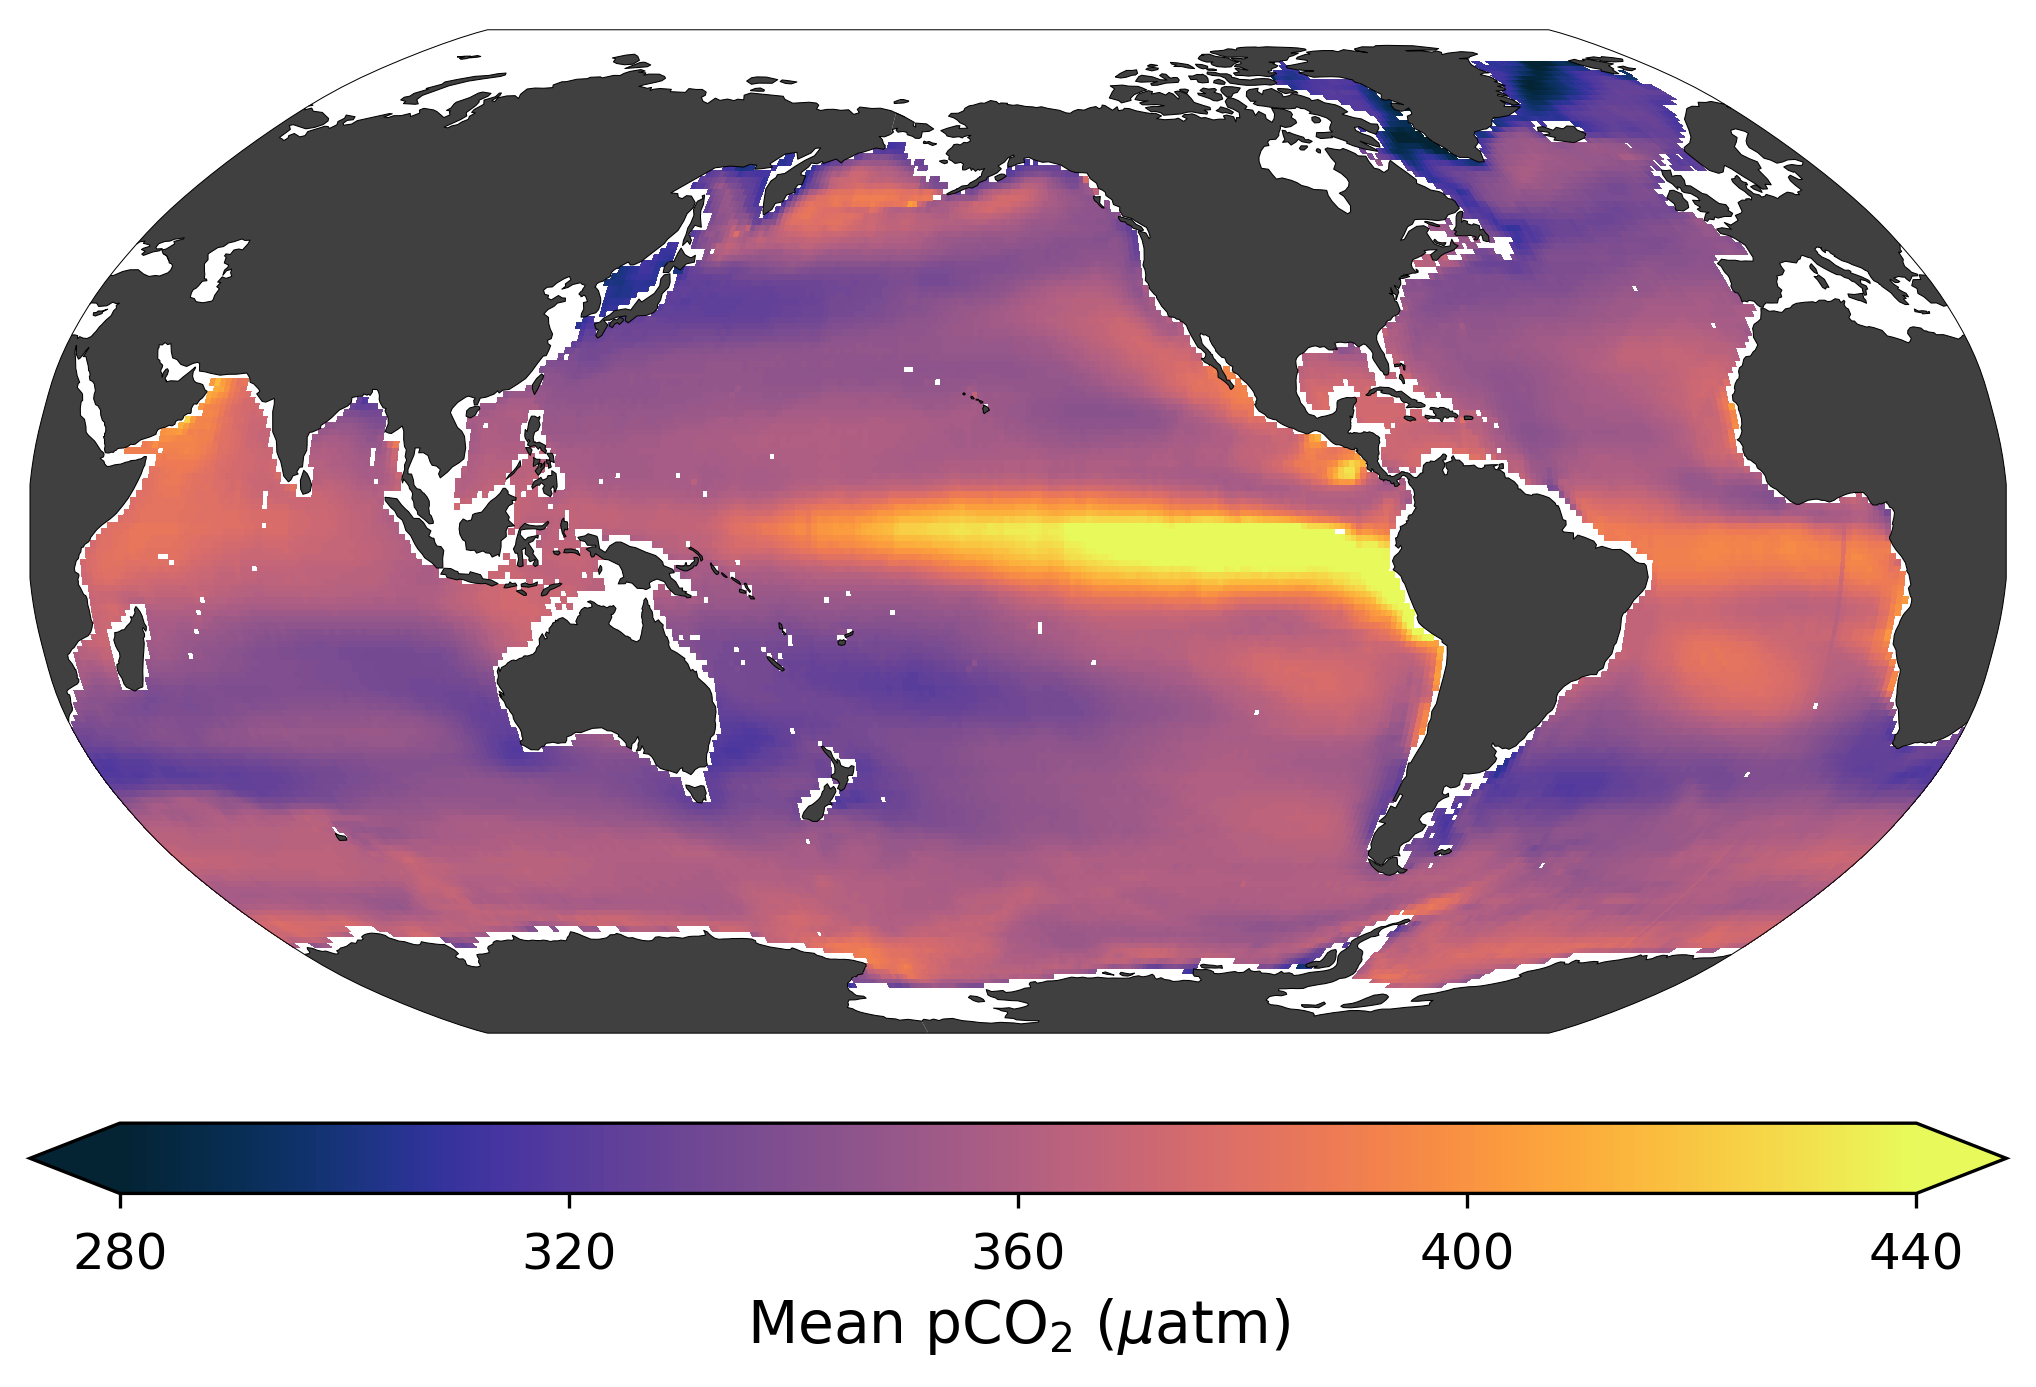

In [16]:
# colormap
vrange = [280, 440, 40]
cmap = cm.cm.thermal

# data to plot
data = ds_spco2['spco2'].sel(time=slice('1982-01','2018-12')).mean(['time'])
data = xr_add_cyclic_point(data, cyclic_coord='lon') 

# make figure
with plt.style.context('seaborn-paper'):
    fig = plt.figure(dpi=300)
    dia = SpatialMap(cbar_location='bottom', cbar_orientation='horizontal')
    sub = dia.add_plot(lat = data['lat'], 
                       lon = data['lon'], 
                       data = data, 
                       vrange=vrange[0:2], 
                       cmap=cmap, 
                       ax=0)
    
    col = dia.add_colorbar(sub, ax=0, extend='both')
    col.ax.tick_params(labelsize=12)
    dia.set_cbar_xlabel(col, 'Mean pCO$_2$ ($\mu$atm)', fontsize=14)
    col.set_ticks(ticks=np.arange(vrange[0], vrange[1]+vrange[2], vrange[2]))

plt.savefig(f'{dir_figs}/mean_spco2_latest.pdf', 
                transparent = True, 
                bbox_inches = 'tight', 
                pad_inches = 0)

# Mean over decades

In [ ]:
%%time

# 1) load pco2 data
data_dir = '/home/gloege/projects/ldeo_hpd/data/model_output/XGB'
ds_spco2 = xr.merge([xr.open_dataset(fl) for fl in glob.glob(f'{data_dir}/XGB*.nc')])

# 1.1) the different models we corrected
# GCB 2020
variables = [ 
    'corrected_cesm_spco2_1x1_A', 
    'corrected_csiro_spco2_1x1_A',
    'corrected_fesom_spco2_1x1_A',
    'corrected_mpi_spco2_1x1_A', 
    'corrected_cnrm_spco2_1x1_A',
    'corrected_ipsl_spco2_1x1_A',
    'corrected_planktom_spco2_1x1_A',
    'corrected_noresm_spco2_1x1_A',
    'corrected_princeton_spco2_1x1_A',
    ]
            
        
# 1.2) make dummy variable of zeros
ds_spco2['spco2'] = ds_spco2['corrected_cesm_spco2_1x1_A']*0

# 1.3) add all predictions together
for var in variables:
    ds_spco2['spco2'] += ds_spco2[f'{var}']
    
# 1.4) divide by number vars to average
ds_spco2['spco2'] = ds_spco2['spco2'] / len(variables)

In [28]:
ds_prod = xr.open_dataset('/local/data/artemis/workspace/gloege/gregor/IPCC-AR6_FCO2_DataProducts_filled_20201118.nc')
ds_prod['lon'] = [lon if lon>0 else lon+360 for lon in ds_prod['lon'].values]
ds_prod['time'] = pd.date_range(
    start=f'1985-01-01T00:00:00.000000000', 
    end=f'2018-12-01T00:00:00.000000000',
    freq='MS') + np.timedelta64(14, 'D')

In [31]:
ds_area = ds_prod['area'].sortby('lon')

In [ ]:
flux_den_prods = (ds_prod['fgco2'].sel(wind=['CCMP2','ERA5','JRA55']).mean('wind')*(12.01/10**15)*ds_area).sum(['lat','lon'])
flux_den_prods_yr = flux_den_prods.groupby('time.year').mean('time')

In [53]:
ds_avg = ds['fgco2'].sel(wind=['CCMP2','ERA5','JRA55']).mean(['wind'])
ds_tmp = (ds_avg*(12.01/10**15)*ds_area).sum(['lat','lon'])

for yr in [1980, 1990, 2000]:
    print(ds_tmp.where((ds['time'].dt.year>=yr) & 
                       (ds['time'].dt.year<(yr+10))).mean('time').values)

print(ds_tmp.where((ds['time'].dt.year>=2010) & 
                   (ds['time'].dt.year<(2016))).mean('time').values)

-1.179551740277062
-1.3550685365635329
-1.4157233309197113
-1.6522936601037406


In [61]:
ds_avg = ds['fgco2'].sel(wind=['CCMP2','ERA5','JRA55']).mean(['wind'])
ds_tmp = ((ds_avg.where(ds_spco2['spco2']>0))*(12.01/10**15)*ds_area).sum(['lat','lon'])

for yr in [1980, 1990, 2000]:
    print(ds_tmp.where((ds['time'].dt.year>=yr) & 
                       (ds['time'].dt.year<(yr+10))).mean('time').values)

print(ds_tmp.where((ds['time'].dt.year>=2010) & 
                   (ds['time'].dt.year<(2016))).mean('time').values)

-1.1124967605587293
-1.2380967864893349
-1.270549102524298
-1.4669152045057698


In [32]:
ds_avg = ds['fgco2'].sel(wind=['CCMP2','ERA5','JRA55']).mean(['wind'])
ds_tmp = (ds_avg*(12.01/10**15)*ds_area).sum(['lat','lon'])

for yr in [1980, 1990, 2000]:
    print(ds_tmp.where((ds['time'].dt.year>=yr) & 
                       (ds['time'].dt.year<(yr+10))).mean('time').values)

print(ds_tmp.where((ds['time'].dt.year>=2010) & 
                   (ds['time'].dt.year<(2016))).mean('time').values)

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 444, wind: 5)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-15 1982-02-15 ... 2018-12-15
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * wind     (wind) object 'NCEP1' 'NCEP2' 'CCMP2' 'ERA5' 'JRA55'
Data variables:
    fgco2    (time, lat, lon, wind) float64 nan nan nan nan ... nan nan nan nan

# boardcase example

In [7]:
## broadcast area to lon and time
lon = np.arange(0.5,360,1)
time = pd.date_range(start='1982-01-01T00:00:00.000000000', 
                     end='2016-12-01T00:00:00.000000000',freq='MS')+ np.timedelta64(14, 'D')
ds_bc = xr.DataArray(np.zeros([len(time),len(lon)]), coords=[('time', time),('lon', lon)])
ds_data, ds_mask = xr.broadcast(area(ds_hpd['lat']), ds_bc)
ds_data = ds_data.transpose('time','lat','lon')
ds_area = ds_data.rename('area').to_dataset()